# Image Classification

***[주의] 본 노트북을 원활히 수행하려면 GPU가 필요합니다.***

본 핸즈온에서는 Kaggle의 Shopee-IET dataset을 사용해서 의류 종류(BabyPants, BabyShirt, womencasualshoes, womenchiffontop)를 구별하는 다중 클래스 분류 모델을 AutoGluon으로 훈련해 보겠습니다.

In [1]:
# GPU 인스턴스를 사용하시면 아래 주석을 해제하고 본 코드 셀을 실행해 주세요.
# !pip install --upgrade mxnet-cu100

In [2]:
import os
import autogluon.core as ag
from autogluon.vision import ImagePredictor

<br>

## 1. Data Preparation and Training

In [3]:
train_dataset, _, test_dataset = ImagePredictor.Dataset.from_folders('https://autogluon.s3.amazonaws.com/datasets/shopee-iet.zip')
print(train_dataset)

data/
├── test/
└── train/
                                                 image  label
0    /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      0
1    /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      0
2    /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      0
3    /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      0
4    /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      0
..                                                 ...    ...
795  /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      3
796  /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      3
797  /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      3
798  /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      3
799  /home/ec2-user/.gluoncv/datasets/shopee-iet/da...      3

[800 rows x 2 columns]


In [4]:
save_path = 'ag-01-img-classification'
!rm -rf $save_path

In [5]:
%%time
predictor = ImagePredictor(path=save_path)
# since the original dataset does not provide validation split, the `fit` function splits it randomly with 90/10 ratio
predictor.fit(train_dataset, hyperparameters={'epochs': 2}) 

INFO:root:`time_limit=auto` set to `time_limit=7200`.
INFO:gluoncv.auto.tasks.image_classification:Randomly split train_data into train[717]/validation[83] splits.
INFO:gluoncv.auto.tasks.image_classification:Starting fit without HPO
INFO:ImageClassificationEstimator:modified configs(<old> != <new>): {
INFO:ImageClassificationEstimator:root.img_cls.model   resnet50_v1 != resnet50_v1b
INFO:ImageClassificationEstimator:root.valid.batch_size 128 != 16
INFO:ImageClassificationEstimator:root.valid.num_workers 4 != 8
INFO:ImageClassificationEstimator:root.train.num_workers 4 != 8
INFO:ImageClassificationEstimator:root.train.data_dir  ~/.mxnet/datasets/imagenet != auto
INFO:ImageClassificationEstimator:root.train.rec_val   ~/.mxnet/datasets/imagenet/rec/val.rec != auto
INFO:ImageClassificationEstimator:root.train.num_training_samples 1281167 != -1
INFO:ImageClassificationEstimator:root.train.lr        0.1 != 0.01
INFO:ImageClassificationEstimator:root.train.rec_train ~/.mxnet/datasets/imagene

CPU times: user 23.8 s, sys: 8.99 s, total: 32.8 s
Wall time: 23.9 s


<br>

## 2. Prediction and Evaluation

### Prediction

In [6]:
def predict_image(image_path, predictor):
    result = predictor.predict(image_path)

    pred_cls_str = result['class'][0]
    pred_cls_score = result['score'][0]
    pred_cls_idx = result['id'][0]
    import cv2
    import matplotlib.pyplot as plt
    im = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
    font = cv2.FONT_HERSHEY_COMPLEX_SMALL
    cv2.putText(im, f'{pred_cls_str} {pred_cls_score:.2f}%', (10,40), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
    plt.figure(figsize=(10, 10))
    plt.imshow(im[:,:,::-1])    

In [7]:
img_idx = 30
image_path = test_dataset.iloc[img_idx]['image']
result = predictor.predict(image_path)
print(result)

       class     score  id
0  BabyShirt  0.833436   1


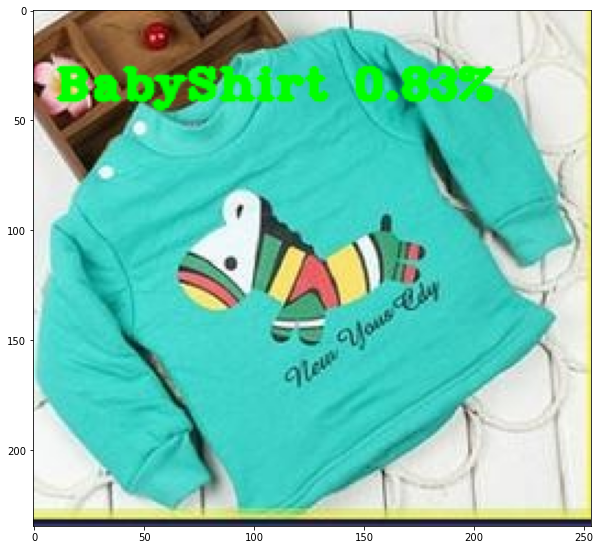

In [8]:
predict_image(image_path, predictor)

### Evaluate on Test Dataset

In [9]:
y_pred = predictor.predict(test_dataset[['image']])
y_pred.tail()

,class,score,id,image
75,womenchiffontop,0.706217,3,/home/ec2-user/.gluoncv/datasets/shopee-iet/da...
76,BabyShirt,0.321218,1,/home/ec2-user/.gluoncv/datasets/shopee-iet/da...
77,womenchiffontop,0.806403,3,/home/ec2-user/.gluoncv/datasets/shopee-iet/da...
78,BabyPants,0.584415,0,/home/ec2-user/.gluoncv/datasets/shopee-iet/da...
79,womenchiffontop,0.696538,3,/home/ec2-user/.gluoncv/datasets/shopee-iet/da...


In [10]:
top1, top5 = predictor.evaluate(test_dataset)
print(f'Top-1 acc. = {top1} , top-5 acc. = {top5}')

Top-1 acc. = 0.7875 , top-5 acc. = 1.0


### Generate image features with a classifier

`predict_feature()`로 입력 이미지에 대한 임베딩 벡터 추출도 쉽게 가능합니다. 아래 코드 예시를 참조해 주세요.

In [11]:
image_path = test_dataset.iloc[30]['image']
feature = predictor.predict_feature(image_path)
print(feature)

                                       image_feature
0  [0.36733916, 0.0, 0.07645006, 1.318171, 0.0019...


/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/gluon/block.py:758: UserWarning: Parameter dense2_weight, dense2_bias is not used by any computation. Is this intended?
  out = self.forward(*args)


### Save and load classifiers

In [12]:
filename = os.path.join(save_path, 'model.ag')
predictor.save(filename)
predictor_loaded = ImagePredictor.load(filename)
# use predictor_loaded as usual
result = predictor_loaded.predict(image_path)
print(result)

       class     score  id
0  BabyShirt  0.833436   1
